<a href="https://colab.research.google.com/github/juliejlai/w266finalproject/blob/main/lstm_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent sequence-to-sequence model for formality translation

**Authors:** Angela Gao, Katie Cason, Julie Lai<br>
**Keras LSTM seq-to-seq model:** https://github.com/keras-team/keras-io/blob/master/examples/nlp/lstm_seq2seq.py <br>
**Date created:** 2021/03/08<br>
**Last modified:** 2021/04/10<br>
**Description:** Recurrent sequence-to-sequence model for formality translation. All iterations of the model are in this notebook.

## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. informal sentences)
    and corresponding target sequences from another domain
    (e.g. formal sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import RepeatVector
import random

## Download the data


In [2]:
from google.colab import files
uploaded = files.upload()


Saving informal_formal_data_entertainment to informal_formal_data_entertainment
Saving informal_formal_family_relationships to informal_formal_family_relationships


In [3]:
fam_file = "informal_formal_family_relationships"
ent_file = "informal_formal_data_entertainment"
fam_data = uploaded[fam_file].decode('utf-8').splitlines()
ent_data = uploaded[ent_file].decode('utf-8').splitlines()
data = fam_data + ent_data

random.seed(42)
random.shuffle(data)

## Configuration


In [4]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space. 
num_samples = len(data)  # Number of samples to train on.


## Prepare the data (Character Level)

In [ ]:
"""
## Making data a character level, sequence of integers

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

lines = data
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[char]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1] = target_token_index[char]

"""

## Prepare the data (Word Level)


In [5]:
## Making data a word level, sequence of integers

input_texts = []
target_texts = []
input_words = set()
target_words = set()

lines = data

for line in lines[: min(num_samples, len(lines))]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for word in list(filter(None, re.split('(\W)',input_text))):
        if word not in input_words:
            input_words.add(word)
    for word in list(filter(None, re.split('(\W)',target_text))):
        if word not in target_words:
            target_words.add(word)

input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(list(filter(None, re.split('(\W)',txt)))) for txt in input_texts])
max_decoder_seq_length = max([len(list(filter(None, re.split('(\W)',txt)))) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(list(filter(None, re.split('(\W)',input_text)))):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(list(filter(None, re.split('(\W)',target_text)))):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1] = target_token_index[word]

Number of samples: 104560
Number of unique input tokens: 45643
Number of unique output tokens: 34918
Max sequence length for inputs: 3978
Max sequence length for outputs: 93


## Split Data on Train and Test Sets

In [6]:
test_size = 100
encoder_input_data_train = encoder_input_data[:-test_size]
decoder_input_data_train = decoder_input_data[:-test_size]
decoder_target_data_train = decoder_target_data[:-test_size]
encoder_input_data_test = encoder_input_data[-test_size:]
decoder_input_data_test = decoder_input_data[-test_size:]
decoder_target_data_test = decoder_target_data[-test_size:]

# Build the models


## Base Model
We ran this model on both character and word level inputs. This model was based off the Keras implementation by François Chollet. We modified this model to take in a sequence of integers, rather than one-hot encoded tokenizations of input sentences, by adding Embedding layers and changing the loss function to `sparse_categorical_entropy`. We also include masking with `mask_zero = True` to skip empty timesteps that occur after a sentence ends.

In [7]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(max_encoder_seq_length, ))
x = Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder = keras.layers.LSTM(latent_dim, return_state=True, activation='tanh')
x, state_h, state_c = encoder(x)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(max_decoder_seq_length, ))
t = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, activation='tanh')
decoder_outputs, hidden_h, hidden_c = decoder_lstm(t, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

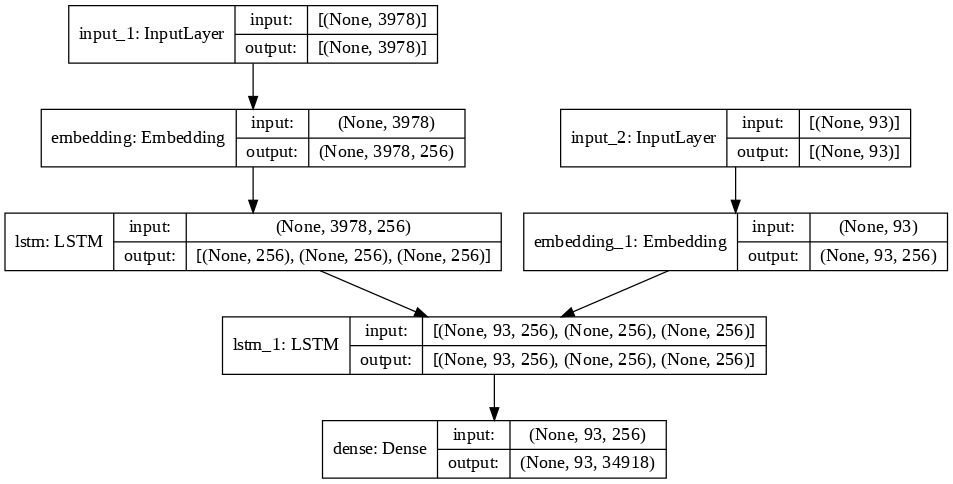

In [18]:
keras.utils.plot_model(model, to_file='base_model.png', show_shapes=True, dpi=90)

## Base Model + Two Time-Distributed Dense and Dropout layers
We add two time-distributed dense and dropout layers after our decoder LSTM layer. We run this model only on word level inputs. 

In [19]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(max_encoder_seq_length, ))
x = Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder = keras.layers.LSTM(latent_dim, return_state=True, activation='tanh')
x, state_h, state_c = encoder(x)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(max_decoder_seq_length, ))
t = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, activation='tanh')
decoder_outputs, hidden_h, hidden_c = decoder_lstm(t, initial_state=encoder_states)

# Two dense layers
decoder_d1 = keras.layers.TimeDistributed(keras.layers.Dense(max_decoder_seq_length, activation="relu"))
decoder_d2 = keras.layers.TimeDistributed(keras.layers.Dense(num_decoder_tokens, activation="softmax"))
decoder_out = decoder_d2(keras.layers.Dropout(rate=.2)(decoder_d1(keras.layers.Dropout(rate=.2)(decoder_outputs))))

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_out)


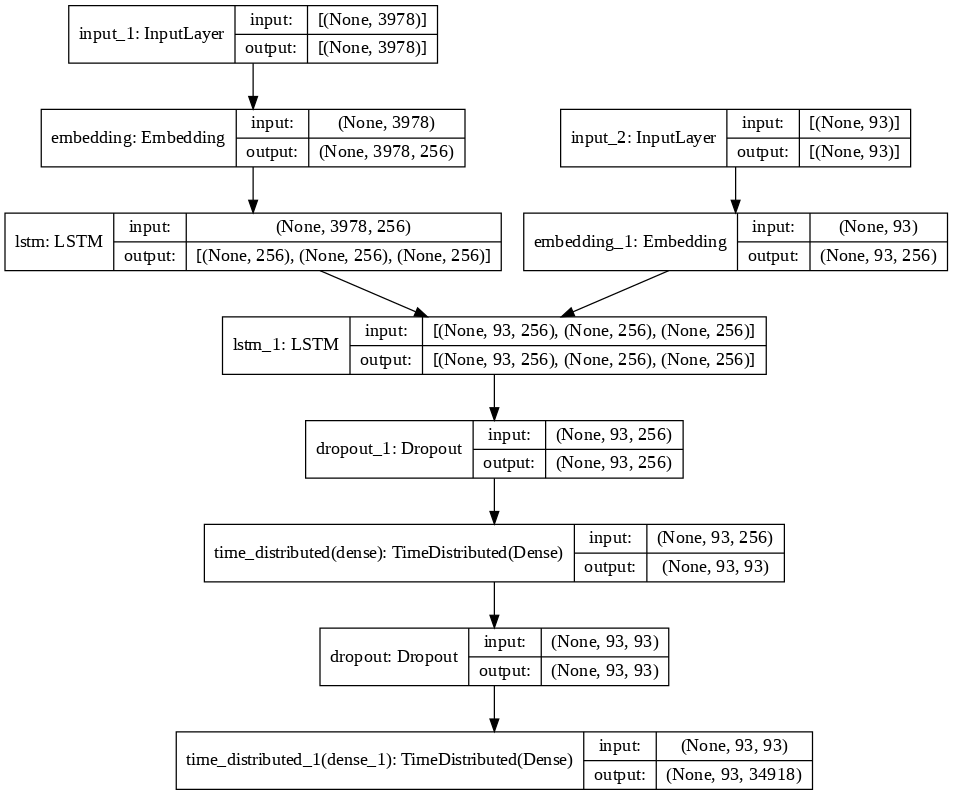

In [21]:
keras.utils.plot_model(model, to_file='dense_model.png', show_shapes=True, dpi=90)

## Base Model with Attention
We add an Attention Layer after our decoder LSTM layer. We did not have enough time to train this model. 

In [ ]:
"""
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(max_encoder_seq_length, ))
x = Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder = keras.layers.LSTM(latent_dim, return_state=True, activation='tanh')
x, state_h, state_c = encoder(x)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(max_decoder_seq_length, ))
t = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, activation='tanh')
att_in = decoder_lstm(t, initial_state=encoder_states)
attention = Attention(max_decoder_seq_length)(att_in)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(attention)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
"""


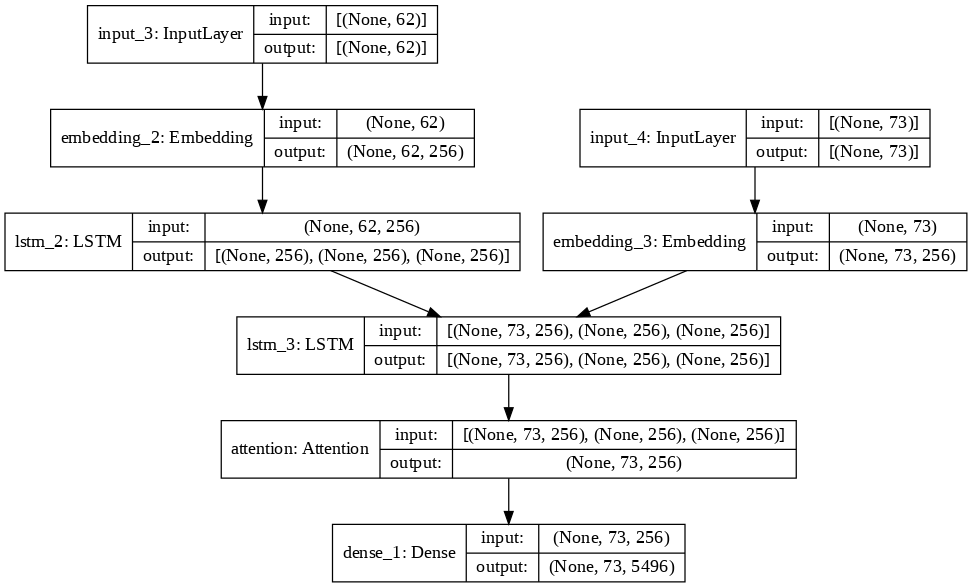

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

## Train the model


In [9]:
model.compile(
    optimizer= keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    [encoder_input_data_train, decoder_input_data_train],
    decoder_target_data_train,
    batch_size=batch_size,
    epochs=5,
    validation_split=0.2,
)


Epoch 1/5
1306/1306 [==============================] - 13340s 10s/step - loss: 0.3360 - accuracy: 0.7258 - val_loss: 0.5213 - val_accuracy: 0.6499
Epoch 2/5
1306/1306 [==============================] - 13067s 10s/step - loss: 0.3163 - accuracy: 0.7373 - val_loss: 0.5283 - val_accuracy: 0.6498
Epoch 3/5
   2/1306 [..............................] - ETA: 3:30:48 - loss: 0.2783 - accuracy: 0.7553

KeyboardInterrupt: ignored

## Saving the model

In [10]:
# model_save_name = 'model_timedist_dense'
model_save_name = 'word_model2'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/word_model2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/word_model2/assets


## Loading the model

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
model_save_name = 'word_model2'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
model = keras.models.load_model(path)

## Evaluating the accuracy of the model on the test set

In [23]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate([encoder_input_data_test, decoder_input_data_test],
    decoder_target_data_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
1/1 [==============================] - 3s 3s/step - loss: 0.5040 - accuracy: 0.6586
test loss, test acc: [0.5040280818939209, 0.6585976481437683]


## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [24]:
# Define sampling models
# Restore the model and construct the encoder and decoder.

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

embedding = model.layers[3] # embedding layer
final_dex = embedding(decoder_inputs)

decoder_lstm = model.layers[5]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# base model
decoder_dense = model.layers[6]
decoder_outputs2 = decoder_dense(decoder_outputs2)

"""
# base model with attention
decoder_dense = model.layers[7]
decoder_outputs2 = decoder_dense(decoder_outputs2)
"""

"""
# base model with two time distributed dense layers and dropout
dropout1 = model.layers[6]
dense1 = model.layers[7]
dropout2 = model.layers[8]
dense2 = model.layers[9]
decoder_outputs2 = dense2(dense1(decoder_outputs2))
"""

decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        # sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_index = np.argmax(output_tokens[0, -1])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char #' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence



You can now generate decoded sentences as such:


In [25]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data_train[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence: just say that i'm her boyfriend
Decoded sentence: the same way that I am told her that I am with a boyfriend.

-
Input sentence: its perfectly fine to wait, whatever is best for you!
Decoded sentence: the best of you are just waiting for yourself.

-
Input sentence: Well, there are alot of has-beens actor/actress so they probably just pick out of a list.
Decoded sentence: the most likely of these children jokes and there are many good friends to win.

-
Input sentence: If I Ain't Got You - Alicia Keys 11.
Decoded sentence: the song is by Rob Carter album.

-
Input sentence: yes i need see hitch-hikers guide film
Decoded sentence: the only party I saw a doctor.

-
Input sentence: I have since re-married, and I still have MY life and I am njoying every second of it!!!!
Decoded sentence: the two of my children and I have been married and I am not going to live it.

-
Input sentence: Send me all your jokes.....I won't steal them...honestly !!
Decoded sentence: the day you

In [26]:
for seq_index in range(10):
    # Try decoding on testing data
    input_seq = encoder_input_data_test[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[-100+seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: What the guy looks like would not be a big deal, but his personality would matter.
Decoded sentence: the man who is a child, he is always like a good looking for the situation to do it.

-
Input sentence: don't you look at handsome men when you are with him?
Decoded sentence: the reason you are looking at you at all women and how much he is interested in you.

-
Input sentence: your teachers aren't gonna be interested when you tell them that the internet told me to do it!
Decoded sentence: the reason you are not to tell me that you want to make the same way when you are trying to get
-
Input sentence: thats easy for me-it would have to be holiday i love it because it gets you movin-literally!
Decoded sentence: the song is when you are going to be it for me, but I was thinking about it after me once in a
-
Input sentence: one day it seems he likes you he send you some signals.
Decoded sentence: the only thing he likes you, but you will take a conversation with you.

-
